In [10]:
import polars as pl
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

graph_df = pd.read_csv("kg.csv")

display(graph_df)

,relation,display_relation,x_index,x_id,x_type,x_name,x_source,y_index,y_id,y_type,y_name,y_source
0,protein_protein,ppi,0,9796,gene/protein,PHYHIP,NCBI,8889,56992,gene/protein,KIF15,NCBI
1,protein_protein,ppi,1,7918,gene/protein,GPANK1,NCBI,2798,9240,gene/protein,PNMA1,NCBI
2,protein_protein,ppi,2,8233,gene/protein,ZRSR2,NCBI,5646,23548,gene/protein,TTC33,NCBI
3,protein_protein,ppi,3,4899,gene/protein,NRF1,NCBI,11592,11253,gene/protein,MAN1B1,NCBI
4,protein_protein,ppi,4,5297,gene/protein,PI4KA,NCBI,2122,8601,gene/protein,RGS20,NCBI
...,...,...,...,...,...,...,...,...,...,...,...,...
8100493,anatomy_protein_absent,expression absent,66747,4720,anatomy,cerebellar vermis,UBERON,5259,140,gene/protein,ADORA3,NCBI
8100494,anatomy_protein_absent,expression absent,63824,1377,anatomy,quadriceps femoris,UBERON,58254,105378952,gene/protein,KLF18,NCBI
8100495,anatomy_protein_absent,expression absent,63826,1379,anatomy,vastus lateralis,UBERON,58254,105378952,gene/protein,KLF18,NCBI
8100496,anatomy_protein_absent,expression absent,64523,2084,anatomy,heart left ventricle,UBERON,58254,105378952,gene/protein,KLF18,NCBI


In [11]:
print(graph_df["relation"].unique())

['protein_protein' 'drug_protein' 'contraindication' 'indication'
 'off-label use' 'drug_drug' 'phenotype_protein' 'phenotype_phenotype'
 'disease_phenotype_negative' 'disease_phenotype_positive'
 'disease_protein' 'disease_disease' 'drug_effect' 'bioprocess_bioprocess'
 'molfunc_molfunc' 'cellcomp_cellcomp' 'molfunc_protein'
 'cellcomp_protein' 'bioprocess_protein' 'exposure_protein'
 'exposure_disease' 'exposure_exposure' 'exposure_bioprocess'
 'exposure_molfunc' 'exposure_cellcomp' 'pathway_pathway'
 'pathway_protein' 'anatomy_anatomy' 'anatomy_protein_present'
 'anatomy_protein_absent']


In [12]:
filtered_df = graph_df[graph_df["relation"].isin(["indication", "contraindication"])]
display(filtered_df)


,relation,display_relation,x_index,x_id,x_type,x_name,x_source,y_index,y_id,y_type,y_name,y_source
346728,contraindication,contraindication,15193,DB05271,drug,Rotigotine,DrugBank,33577,5044,disease,hypertensive disorder,MONDO
346729,contraindication,contraindication,15193,DB05271,drug,Rotigotine,DrugBank,36035,1200_1134_15512_5080_100078,disease,hypertension,MONDO_grouped
346730,indication,indication,16687,DB00492,drug,Fosinopril,DrugBank,33577,5044,disease,hypertensive disorder,MONDO
346731,indication,indication,16687,DB00492,drug,Fosinopril,DrugBank,36035,1200_1134_15512_5080_100078,disease,hypertension,MONDO_grouped
346732,contraindication,contraindication,14483,DB13956,drug,Estradiol valerate,DrugBank,33577,5044,disease,hypertensive disorder,MONDO
...,...,...,...,...,...,...,...,...,...,...,...,...
5776154,indication,indication,27527,31332_100326_31009,disease,Glanzmann thrombasthenia,MONDO_grouped,16634,DB00036,drug,Coagulation factor VIIa Recombinant Human,DrugBank
5776155,indication,indication,38622,2244,disease,factor VII deficiency,MONDO,16634,DB00036,drug,Coagulation factor VIIa Recombinant Human,DrugBank
5776156,indication,indication,28673,9211,disease,congenital factor VII deficiency,MONDO,16634,DB00036,drug,Coagulation factor VIIa Recombinant Human,DrugBank
5776157,contraindication,contraindication,84334,1186,disease,depersonalization disorder,MONDO,18277,DB01202,drug,Levetiracetam,DrugBank


In [13]:
def prune_by_node_types(
    G: nx.Graph,
    keep_types,
    *,
    type_attr: str = "type",
    include_neighbors: bool = False,
    neighbor_radius: int = 1,
    drop_isolates: bool = True,
    largest_component: bool = False,
) -> nx.Graph:
    """
    Keep a subset of nodes based on their node 'type' attribute and return the induced subgraph.

    Args:
        G: NetworkX Graph/DiGraph/Multi(Graph)
        keep_types: iterable of node types to keep (e.g., {"gene/protein", "disease"})
        type_attr: name of the node attribute that stores the type
        include_neighbors: if True, also keep nodes within 'neighbor_radius' hops of kept nodes
        neighbor_radius: hop radius for neighbors when include_neighbors=True
        drop_isolates: remove nodes with degree 0 after pruning
        largest_component: keep only the largest (weakly) connected component at the end

    Returns:
        A pruned copy of G.
    """
    keep_types = set(keep_types)

    # Base set: nodes whose type matches
    base_nodes = {n for n, d in G.nodes(data=True) if d.get(type_attr) in keep_types}

    # Optionally add a halo of neighbors around kept nodes
    if include_neighbors and base_nodes:
        kept = set(base_nodes)
        directed = G.is_directed()
        for s in list(base_nodes):
            # single-source BFS up to neighbor_radius
            reach = nx.single_source_shortest_path_length(
                G if directed else G.to_undirected(as_view=True),
                s,
                cutoff=neighbor_radius,
            )
            kept.update(reach.keys())
        nodes_to_keep = kept
    else:
        nodes_to_keep = base_nodes

    # Induced subgraph on chosen node set
    H = G.subgraph(nodes_to_keep).copy()

    if drop_isolates:
        H.remove_nodes_from([n for n, deg in H.degree() if deg == 0])

    if largest_component and H.number_of_nodes() > 0:
        comps = nx.weakly_connected_components(H) if H.is_directed() \
                else nx.connected_components(H)
        H = H.subgraph(max(comps, key=len)).copy()

    return H

G = nx.from_pandas_edgelist(
    graph_df,
    source="x_id",
    target="y_id",
    edge_attr=["relation", "display_relation"],
    create_using=nx.DiGraph(),
)

disease_drug_subgraph = prune_by_node_types(
    G,
    keep_types=["disease", "drug"],
    include_neighbors=True,
    neighbor_radius=2,
    drop_isolates=True,
)

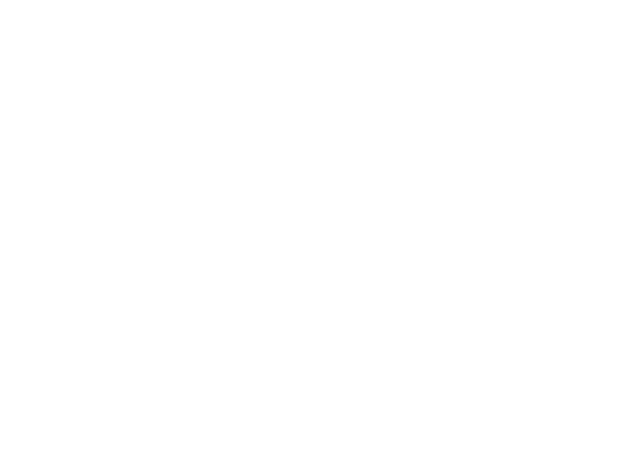

In [17]:
# If your graph is huge, take a small subgraph to view:
H = disease_drug_subgraph.subgraph(list(disease_drug_subgraph.nodes))

pos = nx.spring_layout(H, k=0.35, seed=42)  # force-directed layout

nx.draw_networkx_nodes(H, pos, node_size=20)
nx.draw_networkx_edges(H, pos, alpha=0.25, width=0.5, arrows=False)

plt.axis("off")
plt.tight_layout()
plt.show()

In [15]:
df = pd.read_csv("kg.csv", low_memory=False)

# keep parallel edges (multiple relation types) and direction:
G = nx.from_pandas_edgelist(
    df,
    source="x_id",
    target="y_id",
    edge_attr=["relation", "display_relation"],
    create_using=nx.MultiDiGraph(),
)

# (optional) attach node attributes from both ends if you need them:
nodes = pd.concat([
    df.rename(columns={"x_id":"id","x_type":"type","x_name":"name"})[["id","type","name"]],
    df.rename(columns={"y_id":"id","y_type":"type","y_name":"name"})[["id","type","name"]],
]).drop_duplicates("id")
nx.set_node_attributes(G, nodes.set_index("id").to_dict("index"))




In [18]:
# Build the full MultiDiGraph from the TDC PrimeKG object
G = data.to_nx()

# Keep only drug and disease nodes (and edges between them)
pruned = prune_by_node_types(
    G,
    keep_types=["drug", "disease"],
    include_neighbors=False,          # we only want drug/disease nodes
    drop_isolates=True,           # remove dangling nodes
    largest_component=True,         # keep only the largest connected piece
)

# Draw a small subgraph for quick visual inspection
sample_nodes = list(pruned.nodes)[:100]
H = pruned.subgraph(sample_nodes)

pos = nx.spring_layout(H, k=0.35, seed=42)
nx.draw_networkx_nodes(H, pos, node_size=20)
nx.draw_networkx_edges(H, pos, alpha=0.25, width=0.5, arrows=False)

plt.axis("off")
plt.tight_layout()
plt.show()

KeyboardInterrupt: 